# Task 4 : Image Reconstruction using Matrix Factorisation [4 Marks]

Use the [instructor's notebook](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/movie-recommendation-knn-mf.ipynb) on matrix factorisation, and solve the following questions. Here, ground truth pixel values are missing for particular regions within the image- you don't have access to them.

1. Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank $r$. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics.  **[1 Marks]**

2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.**[3 Marks]**


## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from metrics import calculate_rmse, calculate_psnr

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Utility Functions

In [2]:
def display_image(img, gray=True):
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    
# Mask the image with NaN values 
def mask_image(img, prop, colour=False):
	if colour:
		img_copy = img.clone().permute(1, 2, 0)
	else:
		img_copy = img.clone()
	mask = torch.rand((img_copy.shape[0], img_copy.shape[1])) < prop
    # img_copy[200:300, 200:300] = float('nan')
	if colour:
		img_copy[:, :, 0][mask] = float('nan')
		img_copy[:, :, 1][mask] = float('nan')
		img_copy[:, :, 2][mask] = float('nan')
	else:
		img_copy[mask] = float('nan')
	if colour:
		img_copy = img_copy.permute(2, 0, 1)
	return img_copy, mask

## Loading the image

Shape of the original Image: torch.Size([3, 1599, 899])
Shape of the Cropped image torch.Size([3, 525, 375])
Shape of Greyscale image: torch.Size([525, 375])


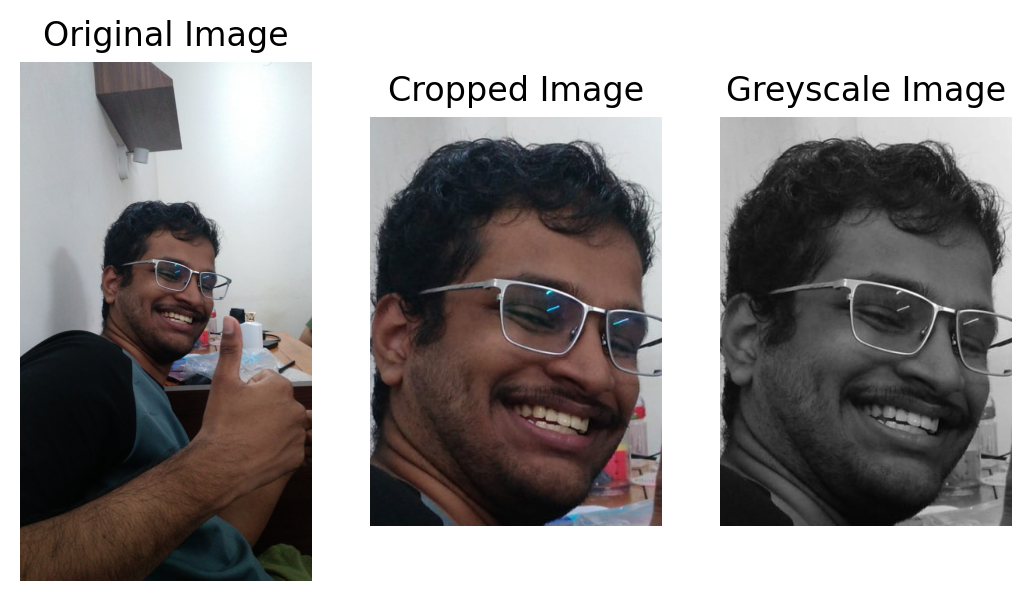

In [3]:
# Read in a image from torchvision
def load_image(path, crop_args=(400, 250, 525, 375)):
	img = torchvision.io.read_image(path)
	print("Shape of the original Image:", img.shape)

	img = (img.clone().detach().to(float))
	plt.subplot(1, 3, 1)
	display_image(img.permute(1, 2, 0) / 255, gray=False)
	plt.title("Original Image")

	img = torchvision.transforms.functional.crop(img.clone().detach().to(float), *crop_args)
	greyscale = img.mean(dim=0, keepdim=False) # convert to grayscale
	print("Shape of the Cropped image", img.shape)
	plt.subplot(1, 3, 2)
	display_image(img.permute(1, 2, 0) / 255)
	plt.title("Cropped Image")
 
	# crop = torchvision.transforms.functional.crop(img, 400, 200, 800, 500)
	print("Shape of Greyscale image:", greyscale.shape)
	plt.subplot(1, 3, 3)
	display_image(greyscale)
	plt.title("Greyscale Image")
	return img, greyscale

img, greyscale = load_image("sample_images/bro.jpg")

## Masking the image

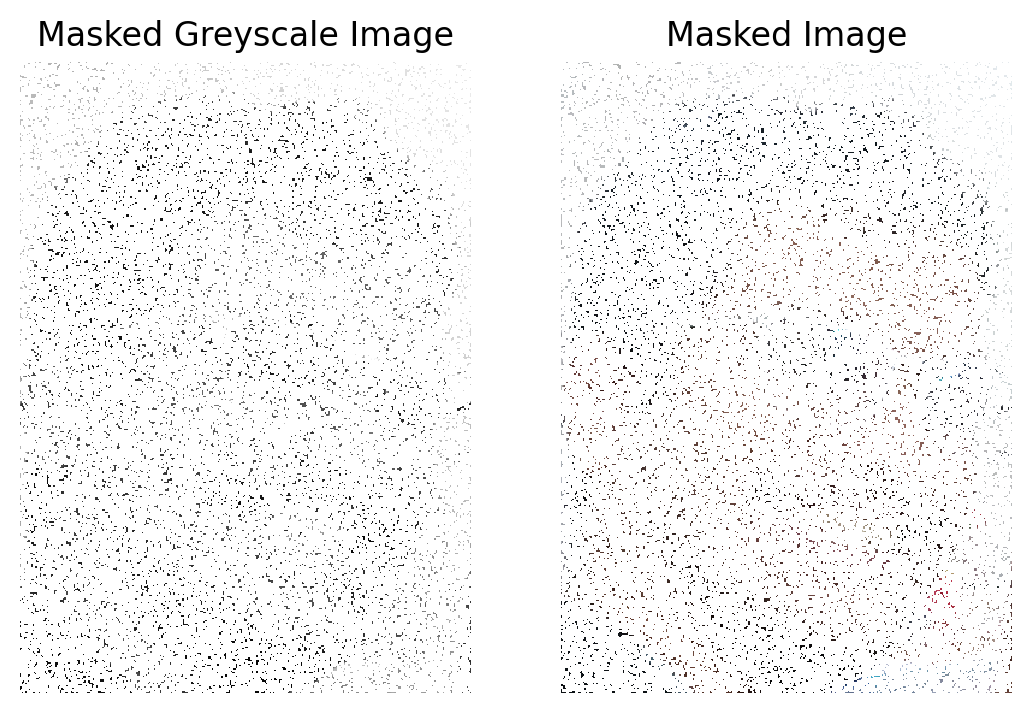

In [4]:
masked_greyscale_img, _= mask_image(greyscale, 0.5)
masked_img, _= mask_image(img, 0.5, colour=True)

plt.subplot(1, 2, 1)
plt.title("Masked Greyscale Image")
display_image(masked_greyscale_img)
plt.subplot(1, 2, 2)
plt.title("Masked Image")
display_image(masked_img.permute(1, 2, 0) / 255, gray=False)

## 1. Do Matrix factorisation on a custom image and choose a suitable value for the rank $r$.

In this section we pick an image and reconstruct it using matrix factorization. We choose a the rank $r$ of the factorised matrix as 50. After that we calculated and reported RMSE and PSNR metrics. We also mask out 30% of the image and then reconstruct it.

After that we also see how the PSNR and the RMSE changes with the rank of the factorised matrix keeping the propotion constant at 0.5 and how the metrics change when we keep the rank constant at 50 and the propotion chaning.

### Factorize the matrix

In this section we factorize the matrix A into two matrices U and V. We then use the Adam optimizer to minimize the loss function. The reconstructed image $\hat A$ is given by:

$$\hat A = UV$$

The loss function in this case is a simple mean squared error loss.

In the case of coloured images, we can factorize the matrix for each channel separately.

The PSNR is calculated using the formula:

$$PSNR = 20 \log_{10} \left( \frac{MAX_I}{\sqrt{MSE}} \right)$$

where $MAX_I$ is the maximum possible pixel value of the image.

### For Greyscale Images

In [35]:
def factorize(A, k, device=torch.device("cpu"), epochs=1000):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(epochs):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [8]:
W, H, loss = factorize(masked_greyscale_img, 50, device=device, epochs=1000)
print("Loss after 1000 epochs:", loss)

Loss after 1000 epochs: tensor(1632.9099, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


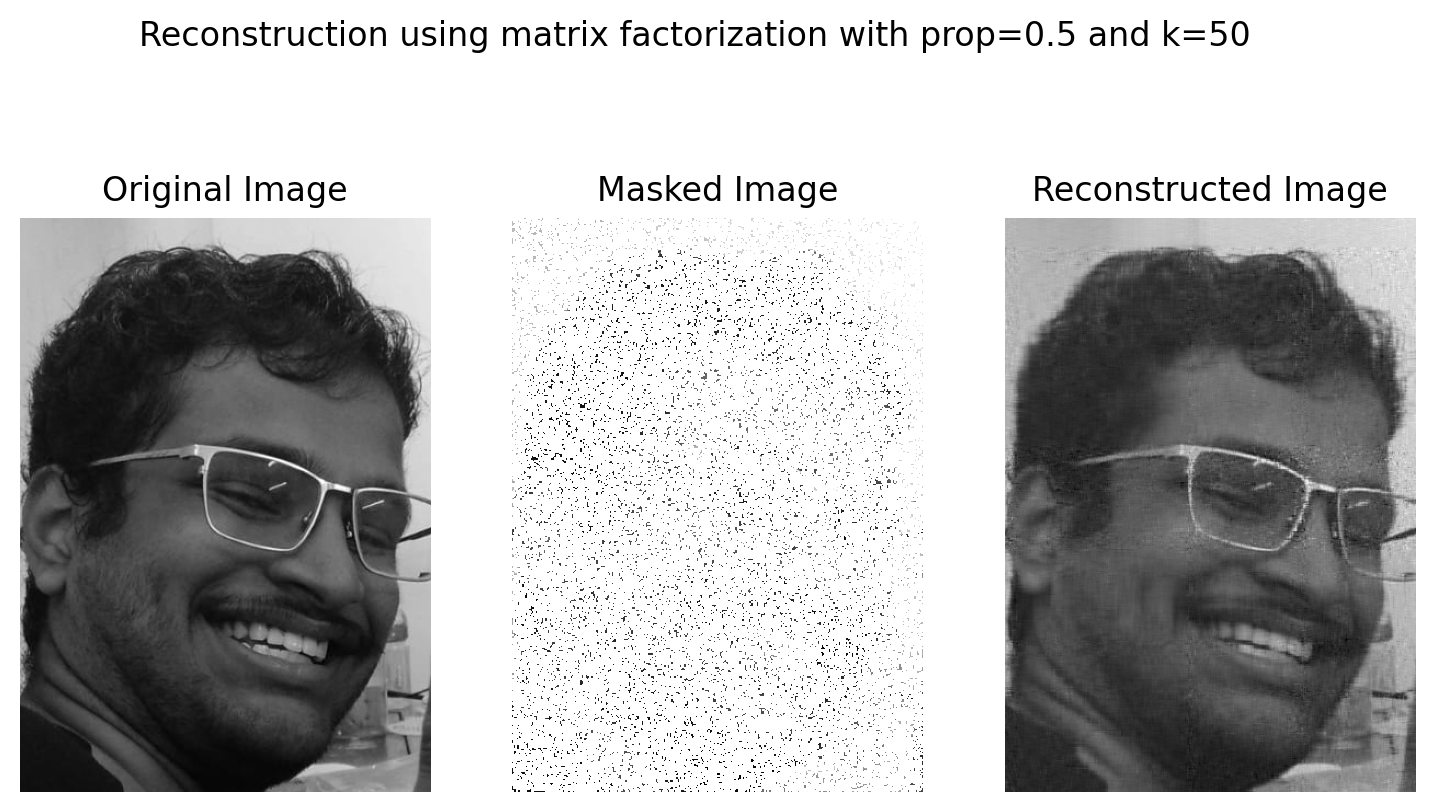

In [9]:
plt.figure(figsize=(9, 5))
plt.suptitle("Reconstruction using matrix factorization with prop=0.5 and k=50")
plt.subplot(1, 3, 1)
plt.title("Original Image")
display_image(greyscale)
plt.subplot(1, 3, 2)
plt.title("Masked Image")
display_image(masked_greyscale_img)
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
display_image(torch.mm(W, H).cpu().detach().numpy())

In [10]:
def calculate_metrics(given_img, prop=0.1, factors=50, colour=False):
	masked_img, mask = mask_image(given_img, prop, colour=colour)
	W, H, loss = factorize(masked_img, factors, device=device)
	reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
	rmse = calculate_rmse(given_img.numpy(), reconstructed_img)
	psnr = calculate_psnr(given_img.numpy(), reconstructed_img)
	return rmse, psnr

rmse, psnr = calculate_metrics(greyscale, 0.3, 50)

print("RMSE for the reconstructed image:", rmse)
print("PSNR for the reconstructed image:", psnr)

RMSE for the reconstructed image: 7.009320582091047
PSNR for the reconstructed image: 31.21728513735974


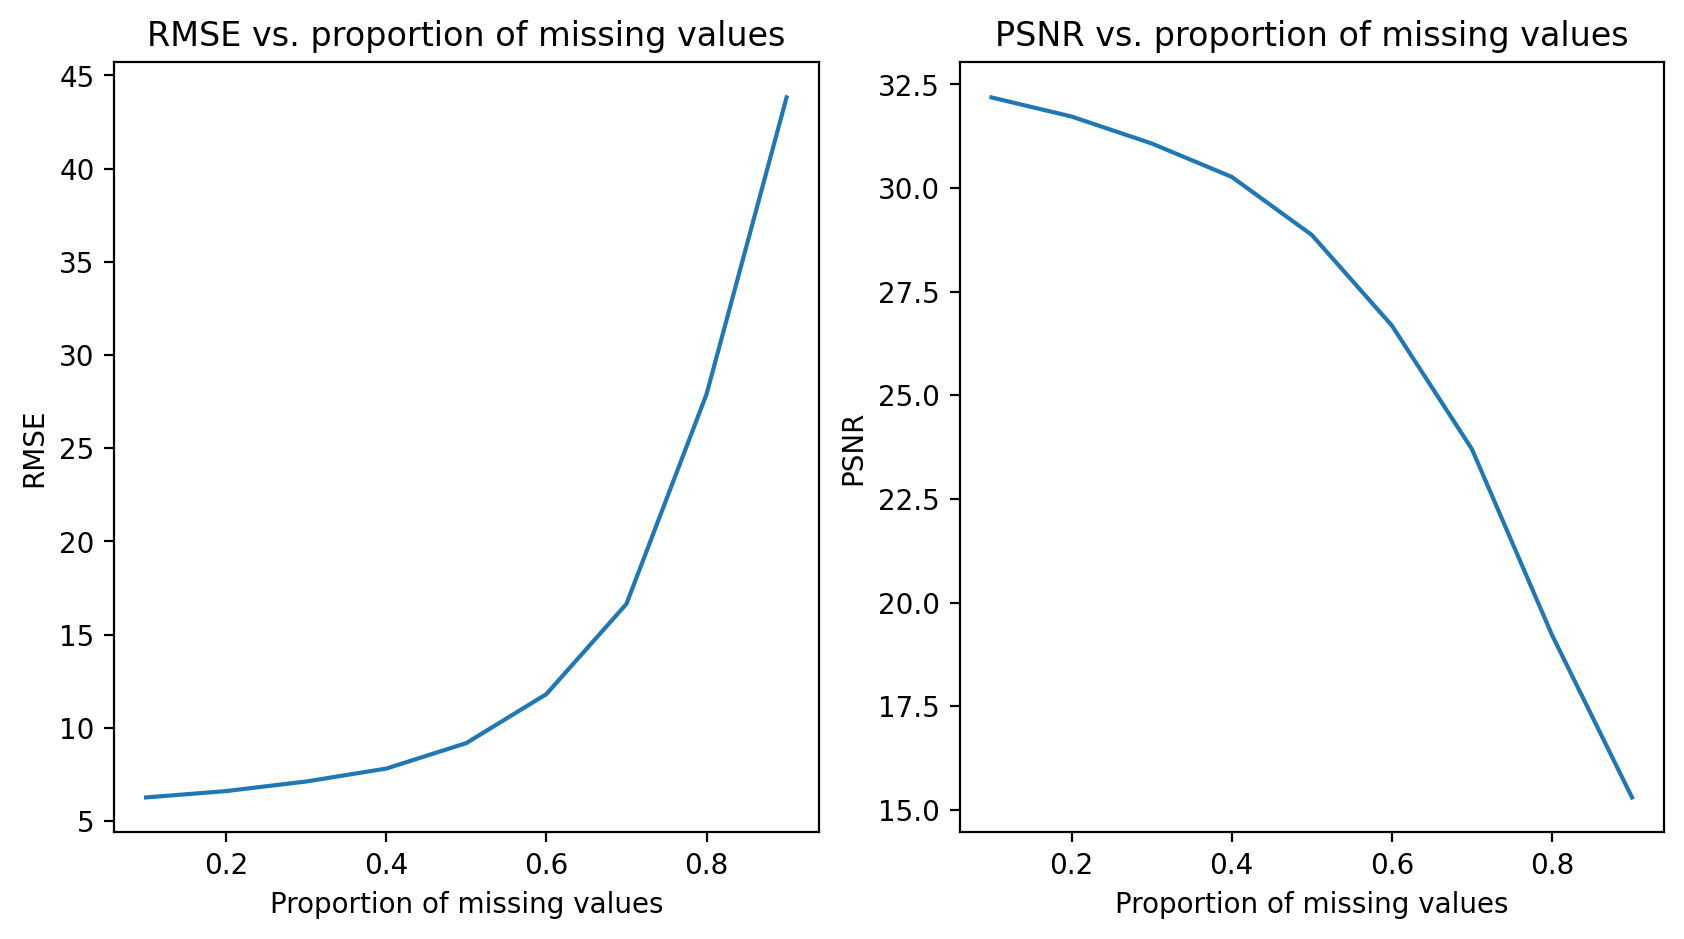

In [11]:
def plot_metric_vs_prop(img, factors=50):
	props = np.linspace(0.1, 0.9, 9)
	rmses = []
	psnrs = []
	for prop in props:
		rmse, psnr = calculate_metrics(img, prop, factors)
		rmses.append(rmse)
		psnrs.append(psnr)
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(props, rmses)
	ax[0].set_title("RMSE vs. proportion of missing values")
	ax[0].set_xlabel("Proportion of missing values")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(props, psnrs)
	ax[1].set_title("PSNR vs. proportion of missing values")
	ax[1].set_xlabel("Proportion of missing values")
	ax[1].set_ylabel("PSNR")
 
plot_metric_vs_prop(greyscale, 50)

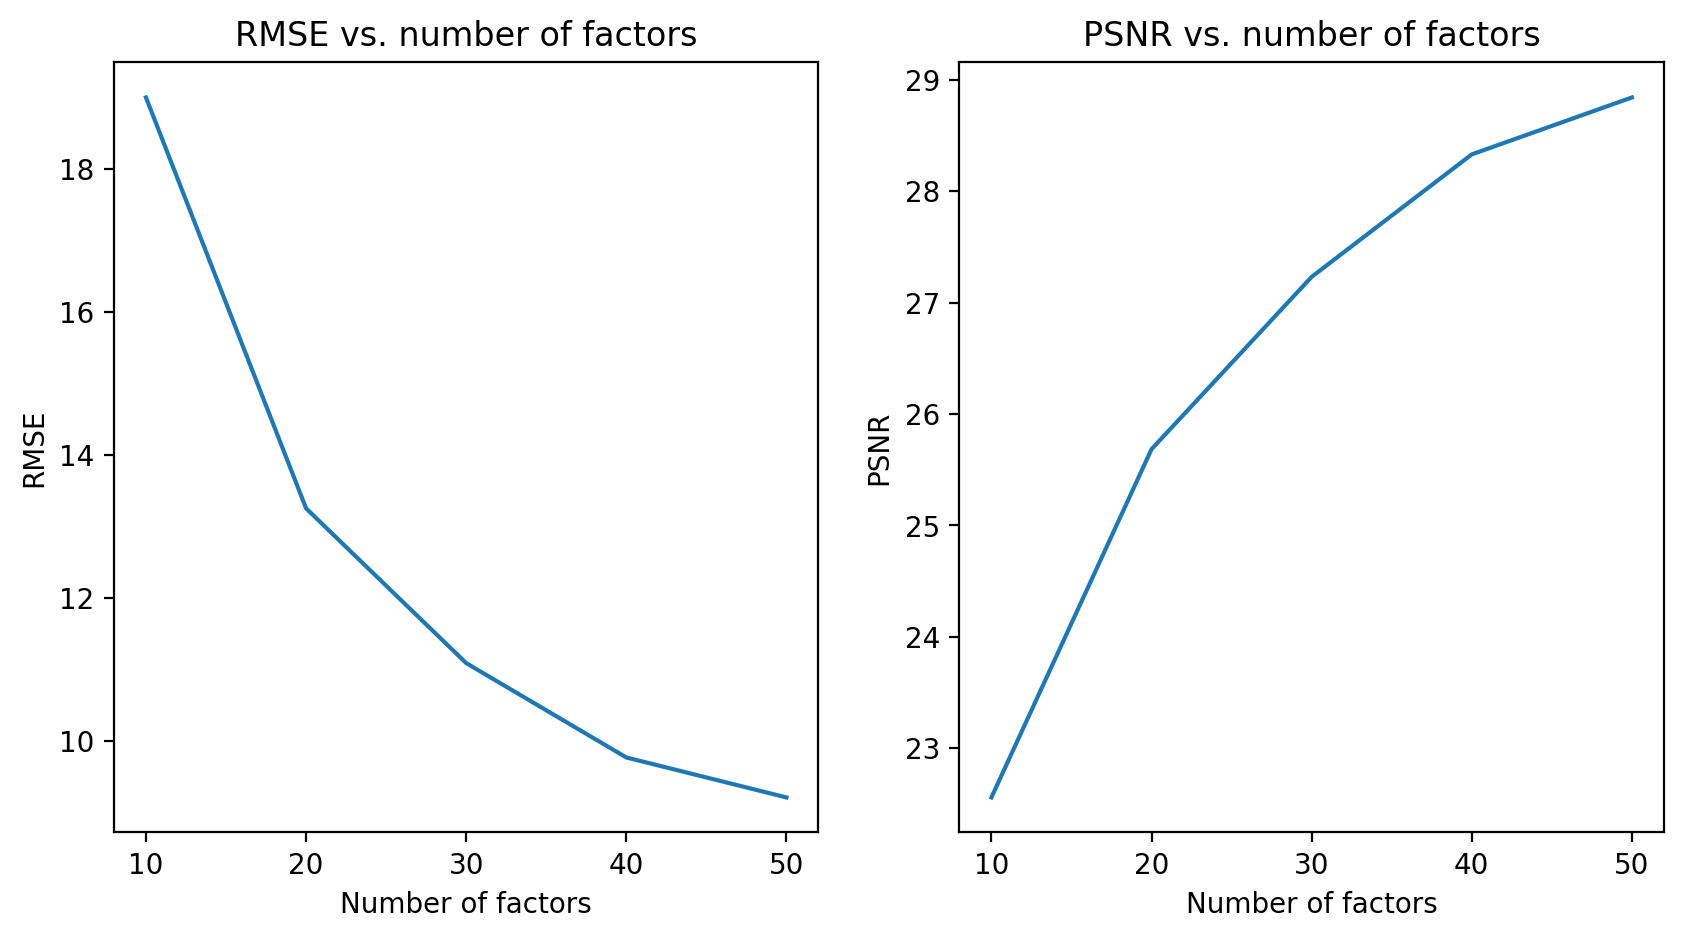

In [12]:
def plot_metric_vs_factors(img, prop=0.3):
	factors = np.arange(10, 51, 10)
	rmses = []
	psnrs = []
	for factor in factors:
		rmse, psnr = calculate_metrics(img, prop, factor)
		rmses.append(rmse)
		psnrs.append(psnr)
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(factors, rmses)
	ax[0].set_title("RMSE vs. number of factors")
	ax[0].set_xlabel("Number of factors")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(factors, psnrs)
	ax[1].set_title("PSNR vs. number of factors")
	ax[1].set_xlabel("Number of factors")
	ax[1].set_ylabel("PSNR")
 
plot_metric_vs_factors(greyscale, 0.5)

### For Coloured Images

In [38]:
def factorize_coloured_img(masked_img, k):
    # masked_img, mask = mask_image(img, prop, colour=True)
    W_R, H_R, loss_R = factorize(masked_img[0, :, :], k, device=device)
    W_G, H_G, loss_G = factorize(masked_img[1, :, :], k, device=device)
    W_B, H_B, loss_B = factorize(masked_img[2, :, :], k, device=device)
    reconstructed_img = torch.stack([torch.mm(W_R, H_R), torch.mm(W_G, H_G), torch.mm(W_B, H_B)])
    reconstructed_img = torch.clamp(reconstructed_img, 0, 255)
    return reconstructed_img, masked_img, loss_R, loss_G, loss_B

def mask_and_reconstruct_coloured_img(img, prop, factors):
	masked_img, _= mask_image(img, prop, colour=True)
	return factorize_coloured_img(masked_img, factors)

reconstructed_img, masked_img, loss_R, loss_G, loss_B = mask_and_reconstruct_coloured_img(img, 0.5, 50)
print("Loss for the red channel:", loss_R)
print("Loss for the green channel:", loss_G)
print("Loss for the blue channel:", loss_B)

Loss for the red channel: tensor(1686.5975, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Loss for the green channel: tensor(1599.6481, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Loss for the blue channel: tensor(1619.5543, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


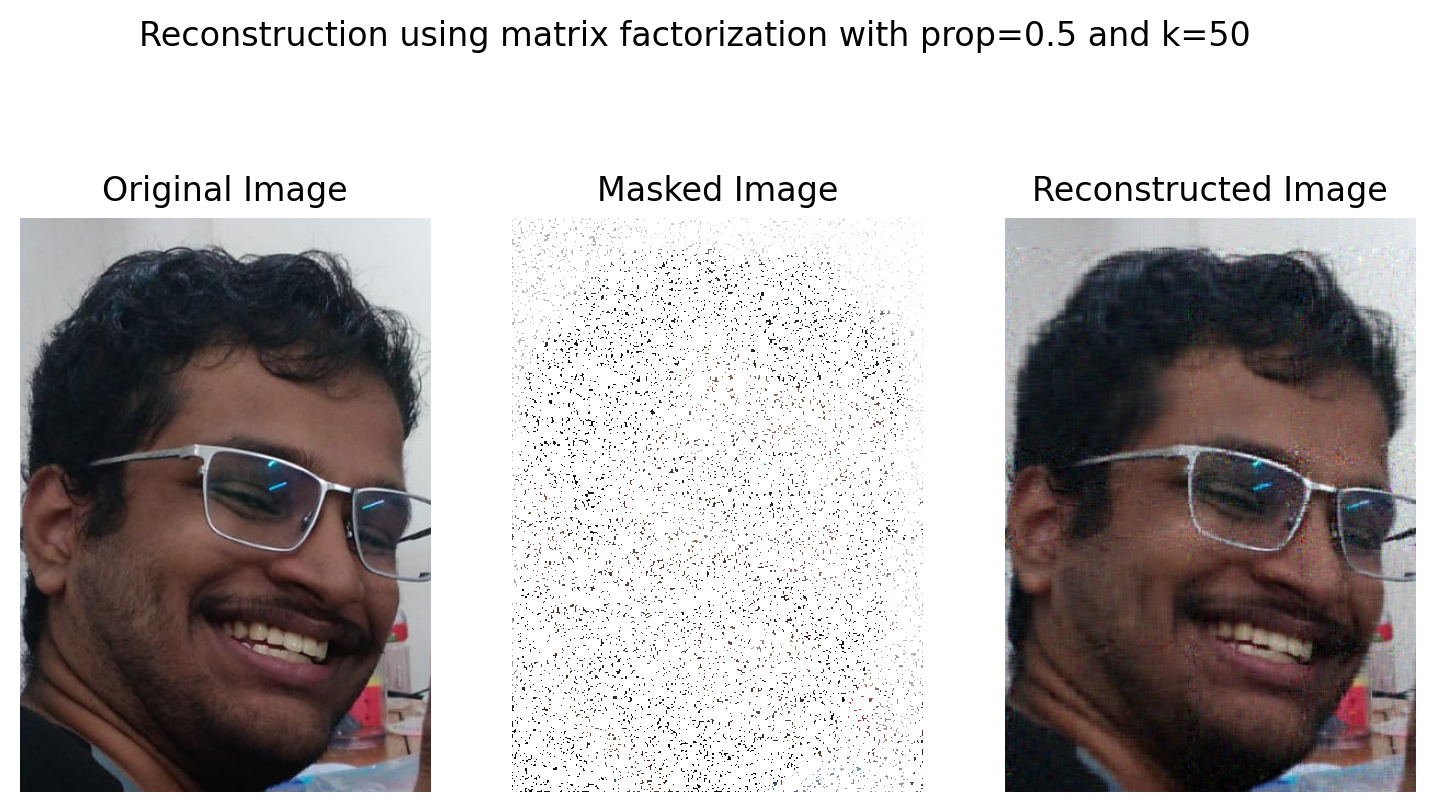

In [14]:
plt.figure(figsize=(9, 5))
plt.suptitle("Reconstruction using matrix factorization with prop=0.5 and k=50")
plt.subplot(1, 3, 1)
plt.title("Original Image")
display_image(img.permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 2)
plt.title("Masked Image")
display_image(masked_img.permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
display_image(reconstructed_img.permute(1, 2, 0).cpu().detach().numpy() / 255, gray=False)

In [15]:
def calculate_metrics_for_coloured_img(img, prop=0.1, factors=50):
	reconstructed_img, _, _, _, _ = mask_and_reconstruct_coloured_img(img, prop, factors)
	rmse = calculate_rmse(img.numpy(), reconstructed_img.cpu().detach().numpy())
	psnr = calculate_psnr(img.numpy(), reconstructed_img.cpu().detach().numpy())
	return rmse, psnr

rmse, psnr = calculate_metrics_for_coloured_img(img, 0.3, 50)
print("RMSE for the reconstructed image:", rmse)
print("PSNR for the reconstructed image:", psnr)

RMSE for the reconstructed image: 7.08908214908599
PSNR for the reconstructed image: 31.119003427983447


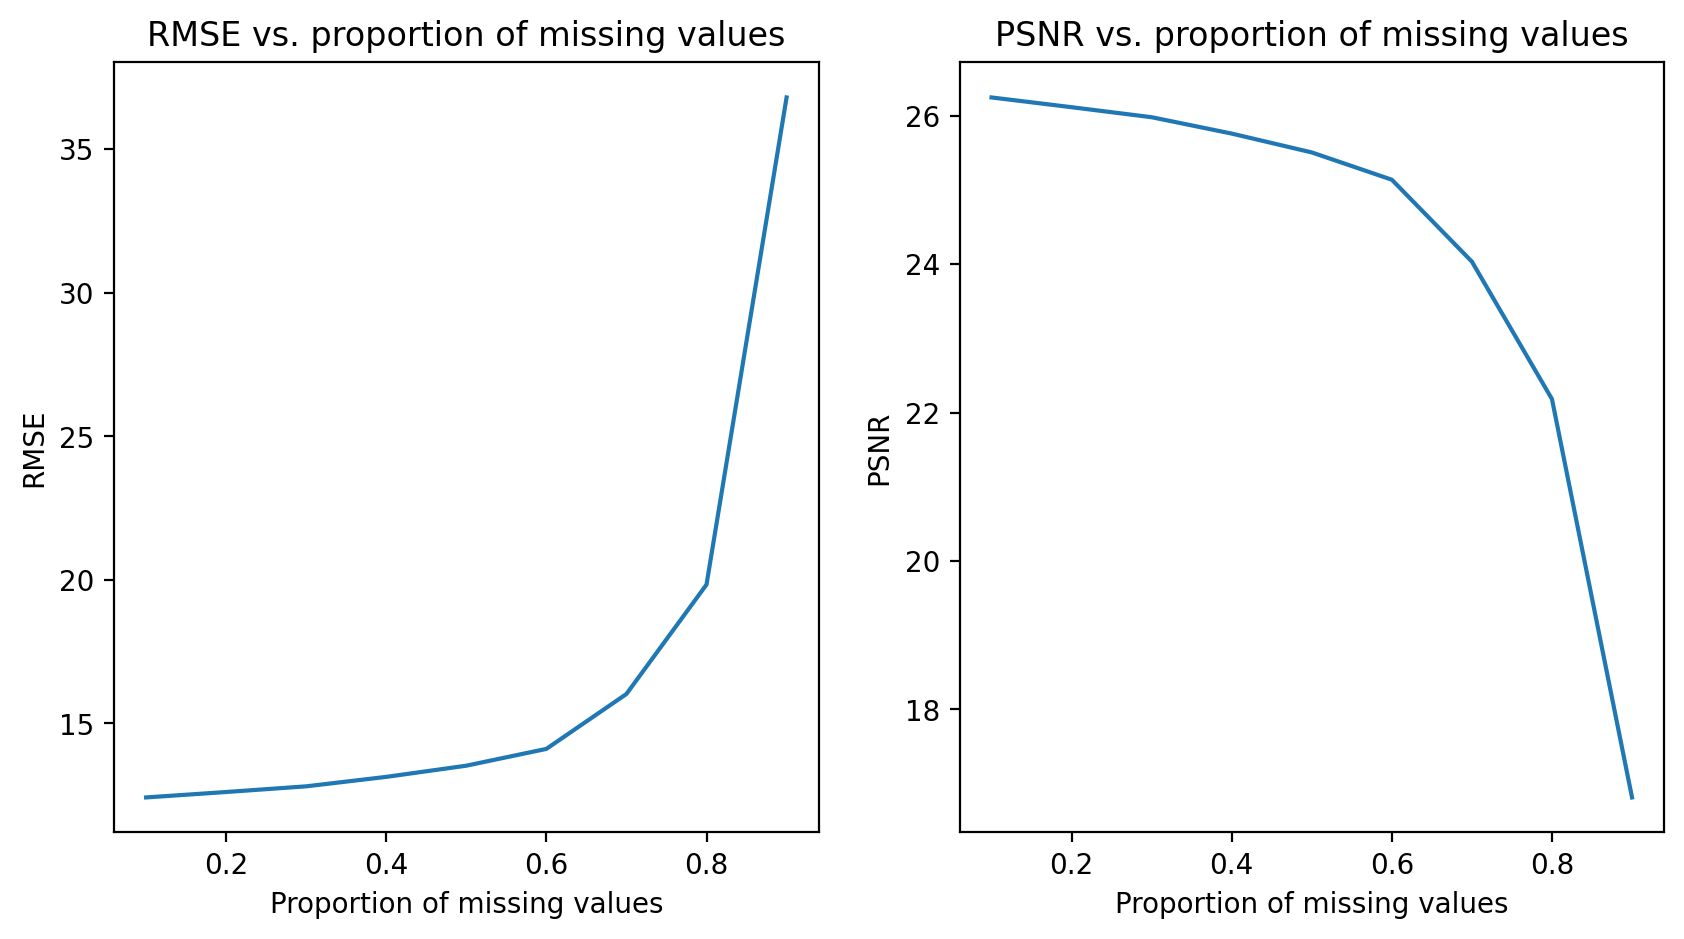

In [16]:
def plot_metric_vs_prop_coloured_img(img, factors=50):
	props = np.linspace(0.1, 0.9, 9)
	rmses = []
	psnrs = []
	for prop in props:
		rmse, psnr = calculate_metrics_for_coloured_img(img, prop, factors)
		rmses.append(rmse)
		psnrs.append(psnr)
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(props, rmses)
	ax[0].set_title("RMSE vs. proportion of missing values")
	ax[0].set_xlabel("Proportion of missing values")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(props, psnrs)
	ax[1].set_title("PSNR vs. proportion of missing values")
	ax[1].set_xlabel("Proportion of missing values")
	ax[1].set_ylabel("PSNR")

plot_metric_vs_prop_coloured_img(img, 20)

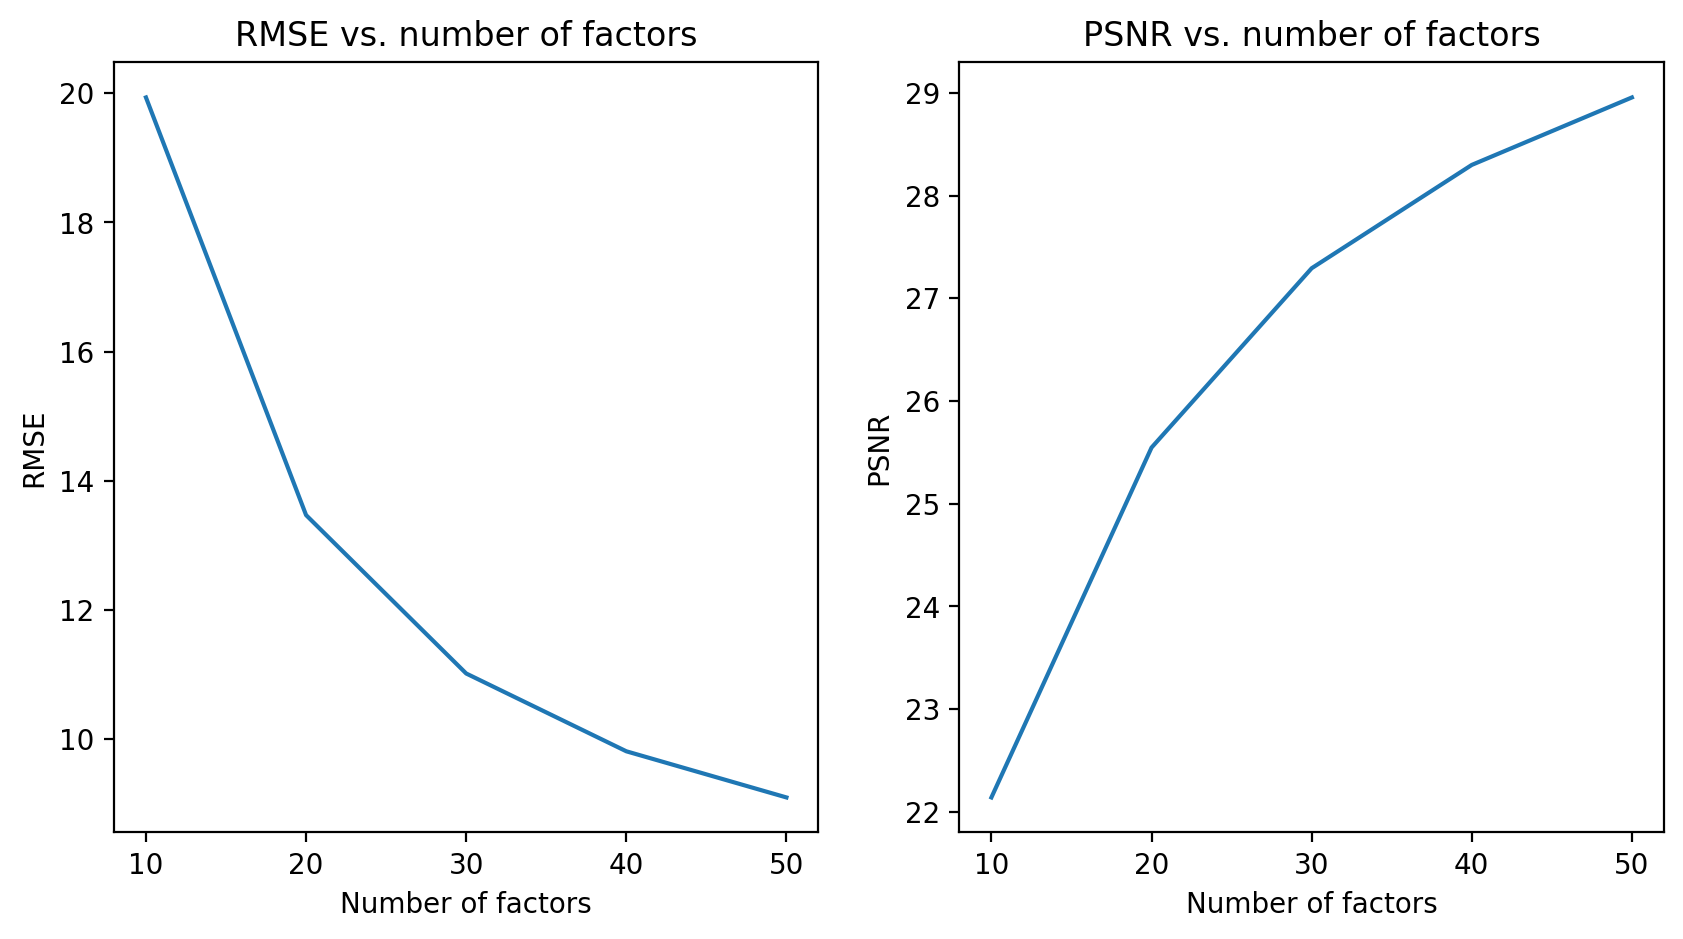

In [17]:
def plot_metric_vs_factors_coloured_img(img, prop=0.3):
	factors = np.arange(10, 51, 10)
	rmses = []
	psnrs = []
	for factor in factors:
		rmse, psnr = calculate_metrics_for_coloured_img(img, prop, factor)
		rmses.append(rmse)
		psnrs.append(psnr)
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(factors, rmses)
	ax[0].set_title("RMSE vs. number of factors")
	ax[0].set_xlabel("Number of factors")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(factors, psnrs)
	ax[1].set_title("PSNR vs. number of factors")
	ax[1].set_xlabel("Number of factors")
	ax[1].set_ylabel("PSNR")
 
plot_metric_vs_factors_coloured_img(img, 0.5)

## 2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.**[3 Marks]**

### Reconstruction using matrix factorisation

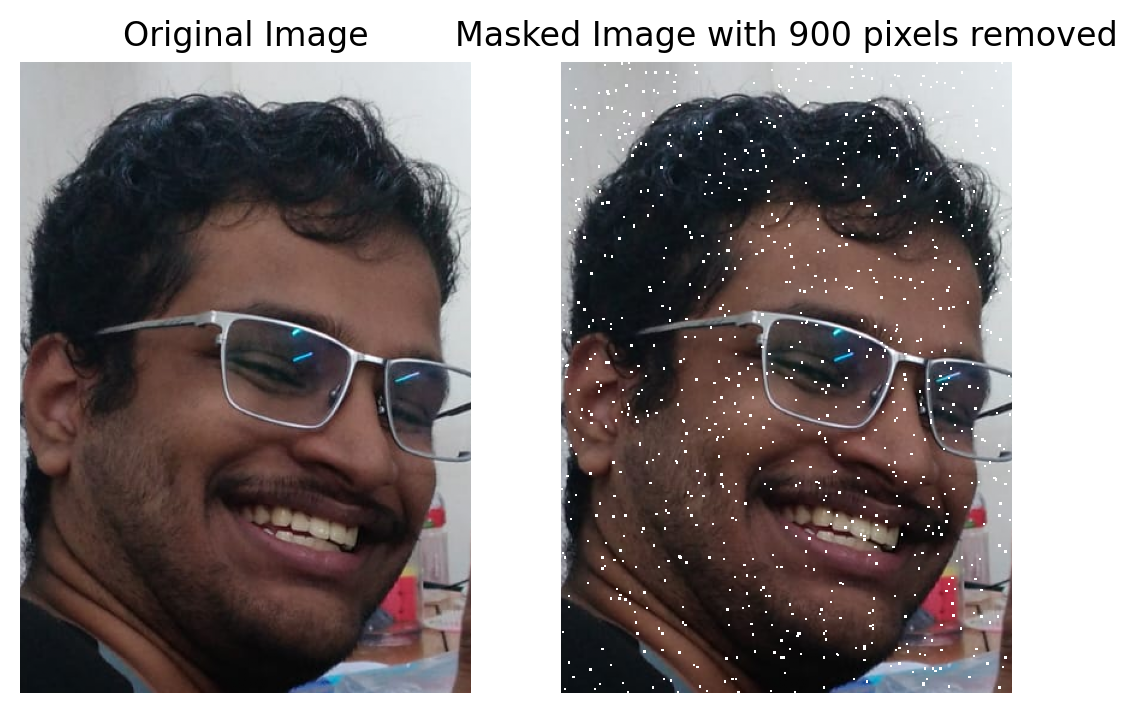

In [41]:
def remove_pixels(img, num_pixels):
	img_copy = img.clone()
	indices = torch.randperm(img.shape[1] * img.shape[2])[:num_pixels]
	ids = torch.zeros((img.shape[1] * img.shape[2]))
	ids[indices] = 1;
	ids = ids.bool()
	ids = ids.reshape(img.shape[1], img.shape[2])
	img_copy[0, :, :][ids] = float('nan')
	img_copy[1, :, :][ids] = float('nan')
	img_copy[2, :, :][ids] = float('nan')
	return img_copy

masked_img = remove_pixels(img, 900)

plt.subplot(1, 2, 1)
plt.title("Original Image")
display_image(img.permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 2, 2)
plt.title("Masked Image with 900 pixels removed")
display_image(masked_img.permute(1, 2, 0) / 255, gray=False)

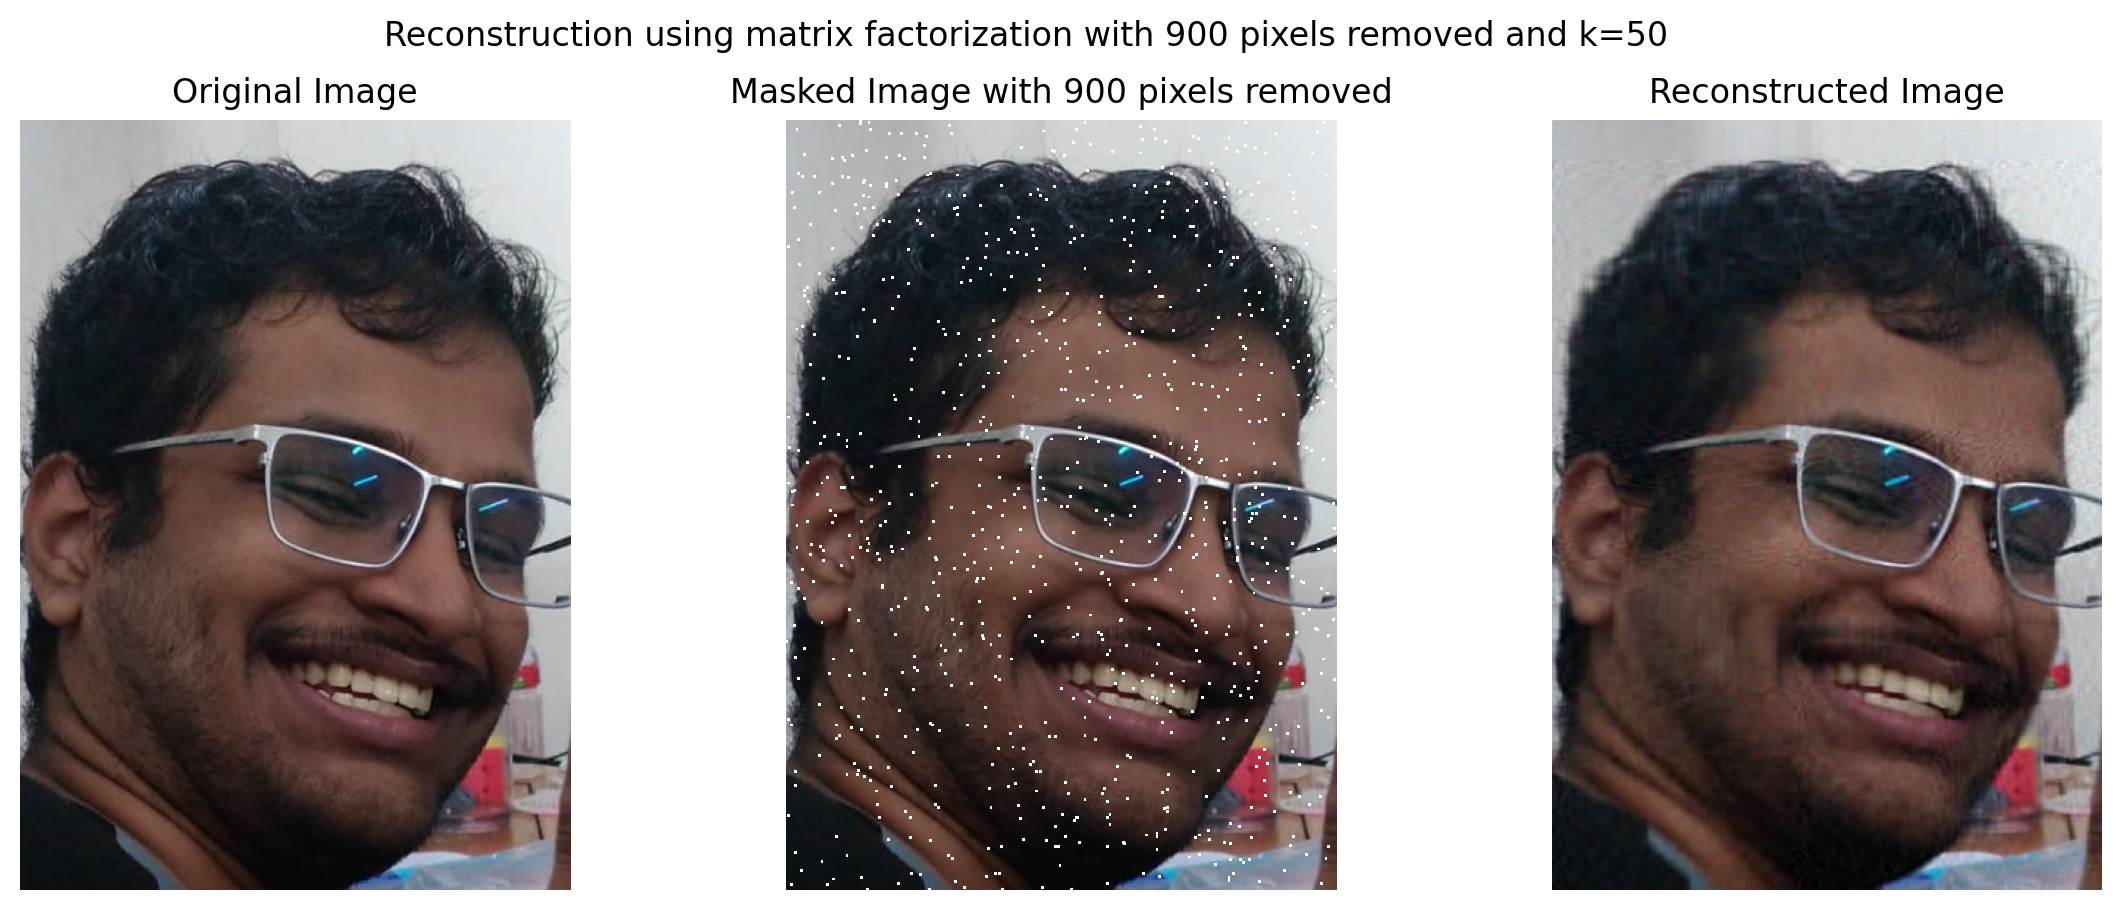

In [42]:
reconstructed_img, _, _, _, _ = factorize_coloured_img(masked_img, 50)
plt.figure(figsize=(14, 5))
plt.suptitle("Reconstruction using matrix factorization with 900 pixels removed and k=50")
plt.subplot(1, 3, 1)
plt.title("Original Image")
display_image(img.permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 2)
plt.title("Masked Image with 900 pixels removed")
display_image(masked_img.permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
display_image(reconstructed_img.permute(1, 2, 0).cpu().detach().numpy() / 255, gray=False)

In [43]:
matrix_factorisation_reconstructed = reconstructed_img.permute(1, 2, 0).cpu().detach().numpy()

### Reconstruction using RFF Features

In [7]:
from sklearn import preprocessing
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

scaler_img = preprocessing.MinMaxScaler().fit(masked_img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [18]:
img_scaled = scaler_img.transform(masked_img.reshape(-1, 1)).reshape(masked_img.shape)
print(img_scaled.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)

num_channels, height, width = img_scaled.shape

(3, 525, 375)


In [10]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

bro_X, bro_Y = create_coordinate_map(img_scaled)

bro_X.shape, bro_Y.shape

(torch.Size([196875, 2]), torch.Size([196875, 3]))

In [11]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(bro_X.cpu())

# Scale the X coordinates
bro_X_scaled = scaler_X.transform(bro_X.cpu())

# Move the scaled X coordinates to the GPU
bro_X_scaled = torch.tensor(bro_X_scaled).to(device)

# Set to dtype float32
bro_X_scaled = bro_X_scaled.float()

#### Utils

In [16]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    
    
    # create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    mask = ~torch.isnan(Y[:, 0])
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        loss = criterion(outputs[mask, :], Y[mask, :])
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

def generate_reconstructed_image(net, X, height, width, num_channels, device = torch.device("cuda")):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    
    return: torch.Tensor of shape (height, width, num_channels) (the reconstructed image)
    device: str, either 'cpu' or 'cuda'
    """
    # Ensure the model and input are on the same device
    net = net.to(device)
    X = X.to(device)

    net.eval()
    with torch.no_grad():
        outputs = net(X)  # Generate reconstructed image
        outputs = outputs.reshape(height, width, num_channels)  # Reshape to image dimensions
    
    return outputs.cpu()  # Return reconstructed image on CPU for plotting

def print_reconstruction_metrics(original_img, reconstructed_img, title="Reconstruction Metrics"):
    """
    Prints the RMSE and PSNR between the original and reconstructed images.

    original_img: torch.Tensor of shape (num_channels, height, width)
    reconstructed_img: torch.Tensor of shape (num_channels, height, width)
    """
    original_img = original_img.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    reconstructed_img = reconstructed_img.cpu().numpy()

    def calculate_rmse(original, compressed):
        mse = np.mean((original - compressed) ** 2)
        rmse = np.sqrt(mse)
        return rmse

    def calculate_psnr(original, compressed):
        mse = np.mean((original - compressed) ** 2)
        if mse == 0:
            return float('inf')
        max_pixel = np.max(original)
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
        return psnr
    # Calculate RMSE and PSNR
    rmse = calculate_rmse(original_img, reconstructed_img)
    psnr = calculate_psnr(original_img, reconstructed_img)

    # Print results
    print(f"{title}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"PSNR: {psnr:.2f} dB")

In [13]:
X_rff = create_rff_features(bro_X_scaled, 37500, 0.008)

print(X_rff.shape)

# Initialize the LinearModel with input size equal to the number of RFF features
# The output size is 3, corresponding to the RGB channels of the image
net = LinearModel(X_rff.shape[1], 3)

# Move the model to the appropriate device (GPU or CPU)
net.to(device)

torch.Size([196875, 37500])


LinearModel(
  (linear): Linear(in_features=37500, out_features=3, bias=True)
)

In [14]:
train(net, 0.005, X_rff, bro_Y, 2500)

Epoch 0 loss: 0.156754


Epoch 100 loss: 0.021274
Epoch 200 loss: 0.010049
Epoch 300 loss: 0.005029
Epoch 400 loss: 0.002674
Epoch 500 loss: 0.001574
Epoch 600 loss: 0.001073
Epoch 700 loss: 0.000853
Epoch 800 loss: 0.000758
Epoch 900 loss: 0.000716
Epoch 1000 loss: 0.000695
Epoch 1100 loss: 0.000684
Epoch 1200 loss: 0.000675
Epoch 1300 loss: 0.000669
Epoch 1400 loss: 0.000664
Epoch 1500 loss: 0.000659
Epoch 1600 loss: 0.000655
Epoch 1700 loss: 0.000652
Epoch 1800 loss: 0.000649
Epoch 1900 loss: 0.000647
Epoch 2000 loss: 0.000644
Epoch 2100 loss: 0.000642
Epoch 2200 loss: 0.000641
Epoch 2300 loss: 0.000639
Epoch 2400 loss: 0.000638


0.000636530457995832

torch.Size([525, 375, 3])


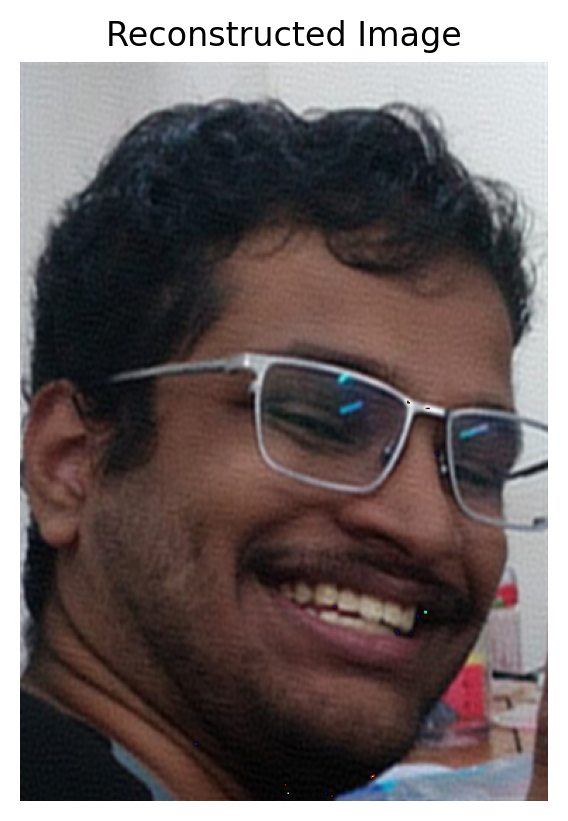

In [44]:
reconstructed_image = generate_reconstructed_image(net, X_rff, height, width, num_channels)
print(reconstructed_image.shape)
# Convert the reconstructed tensor to numpy array and scale it back to [0, 255]
reconstructed_image_np = (reconstructed_image.cpu().numpy() * 255).astype(np.uint8)

# Display the image using matplotlib
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')  # Hide axes
plt.show()

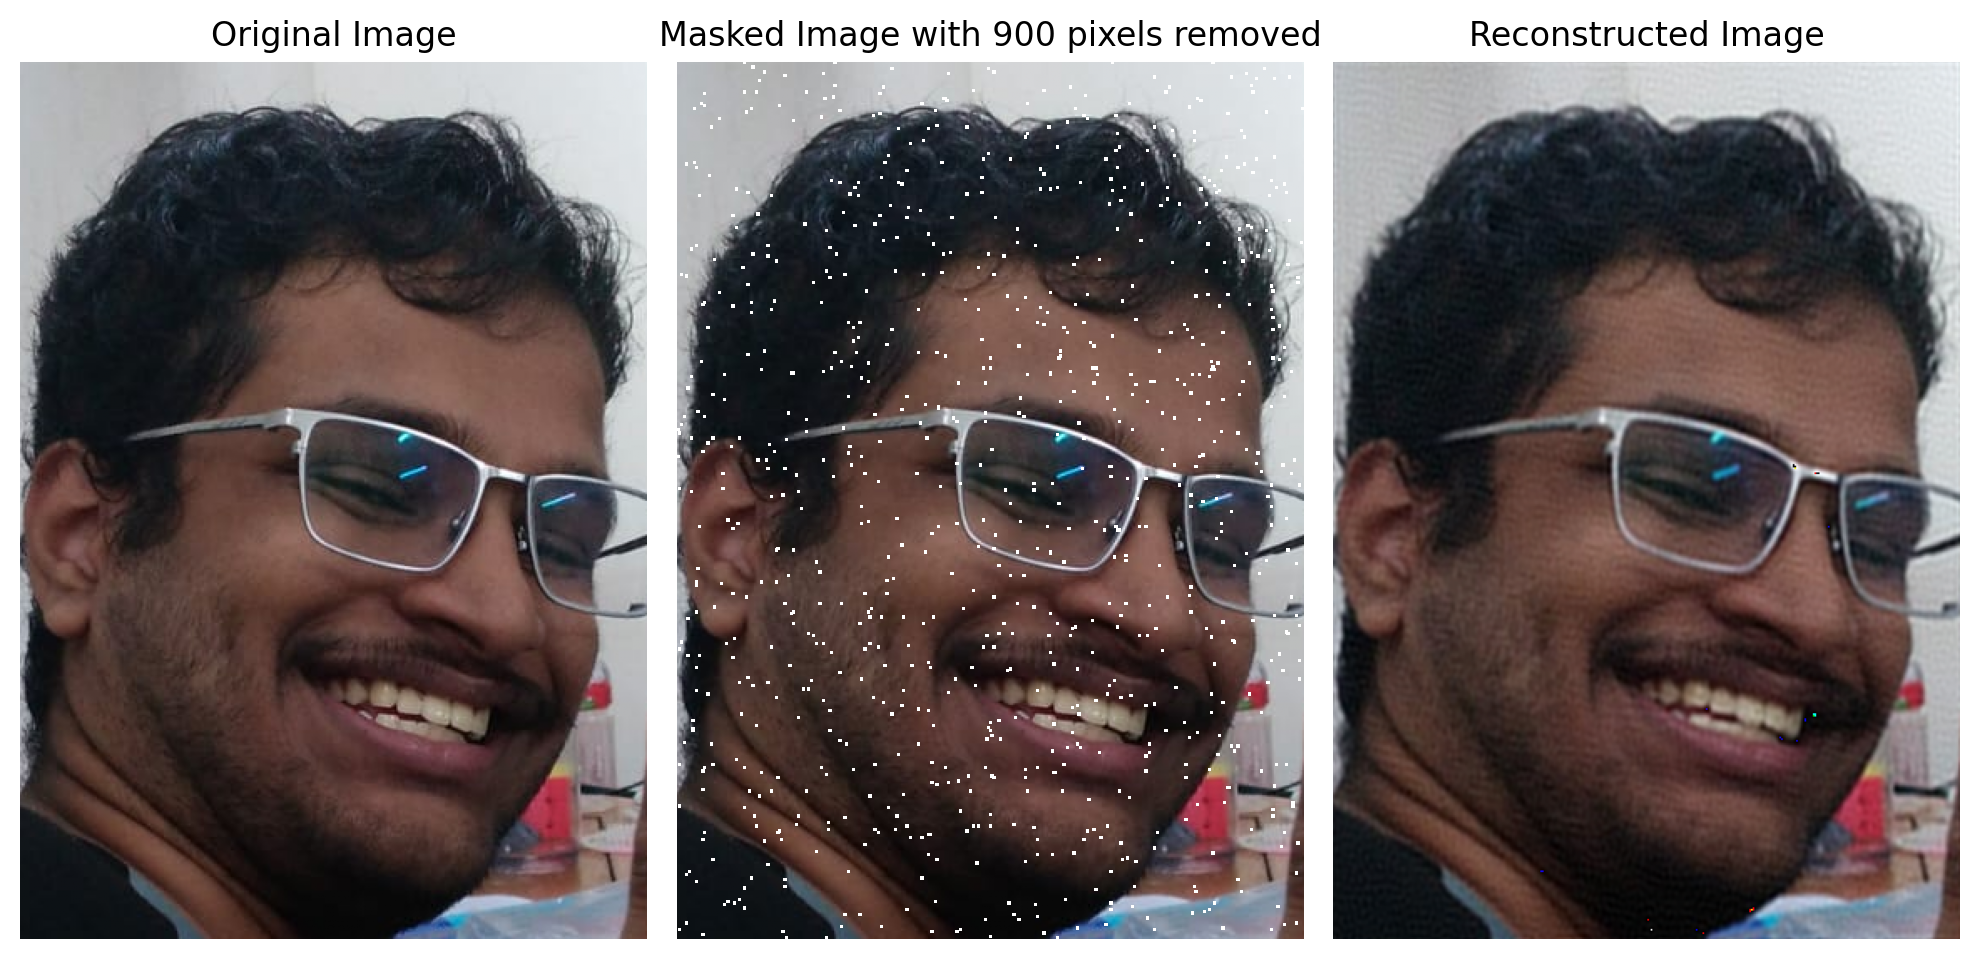

In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
display_image(img.permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 2)
plt.title("Masked Image with 900 pixels removed")
display_image(masked_img.permute(1, 2, 0) / 255, gray=False)
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
display_image(reconstructed_image_np, gray=False)
plt.tight_layout()

### Comparing results for both the methods

In [47]:
def calculate_metrics(gt, pred):
    rmse = calculate_rmse(gt, pred)
    psnr = calculate_psnr(gt, pred)
    return rmse, psnr

rmse_fact, psnr_fact = calculate_metrics(img.permute(1, 2, 0).cpu().numpy(), matrix_factorisation_reconstructed)
rmse_rff, psnr_rff = calculate_metrics(img.permute(1, 2, 0).cpu().numpy(), reconstructed_image_np)

print("Matrix Factorization:")
print(f"RMSE: {rmse_fact:.4f}")
print(f"PSNR: {psnr_fact:.2f} dB")

print("\nRandom Fourier Features + Linear regression:")
print(f"RMSE: {rmse_rff:.4f}")
print(f"PSNR: {psnr_rff:.2f} dB")

Matrix Factorization:
RMSE: 6.1067
PSNR: 32.41 dB

Random Fourier Features + Linear regression:
RMSE: 6.8225
PSNR: 31.45 dB
